# Urban Heat in Berlin

This exercise ...


In [1]:
import os
import geopandas as gpd
import seaborn as sns
import cartopy.crs as ccrs
import rasterio
import rioxarray
import matplotlib.pyplot as plt

os.getcwd()

'd:\\gitscripts\\teaching\\teaching\\heat'

In [2]:
datafolder = "D:/Seafile/Meine Bibliothek/teaching/teaching-heat/data"
os.listdir(datafolder)


['city',
 'cooling-hours',
 'heatwave-magnitude-index',
 'HWMI_2011_2020_present_30.tif',
 'osm_water_berlin.gpkg',
 'tropical-nights',
 'wet-bulb-28']

In [3]:
districts = gpd.read_file(datafolder + "/city/Bezirksgrenzen.shp")
districts.explore("gem", tiles="CartoDB positron")

<AxesSubplot: >

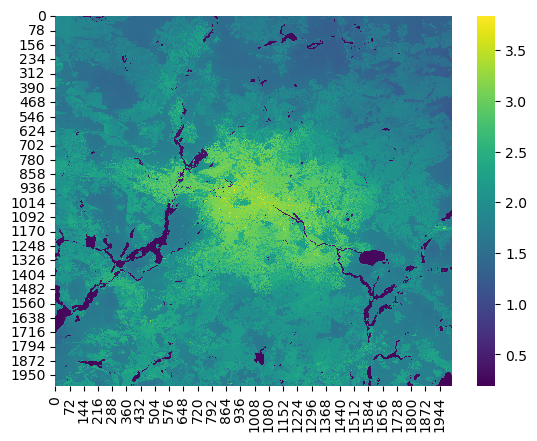

In [4]:
# load the raster file "HWMI_2011_2020_present_30.tif" and display it
# note that raster data requires the rasterio package
hwmi = rasterio.open(datafolder + "/HWMI_2011_2020_present_30.tif")
hwmi.read(1)
# display the raster data using matplotlib
#import matplotlib.pyplot as plt
#plt.imshow(hwmi.read(1), cmap="viridis")

# display the raster data using seaborn
sns.heatmap(hwmi.read(1), cmap="viridis")


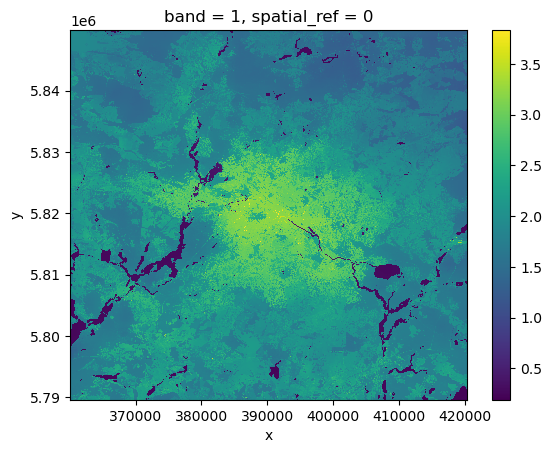

In [5]:
hwmi=rioxarray.open_rasterio(datafolder + "/HWMI_2011_2020_present_30.tif")
hwmi.plot()

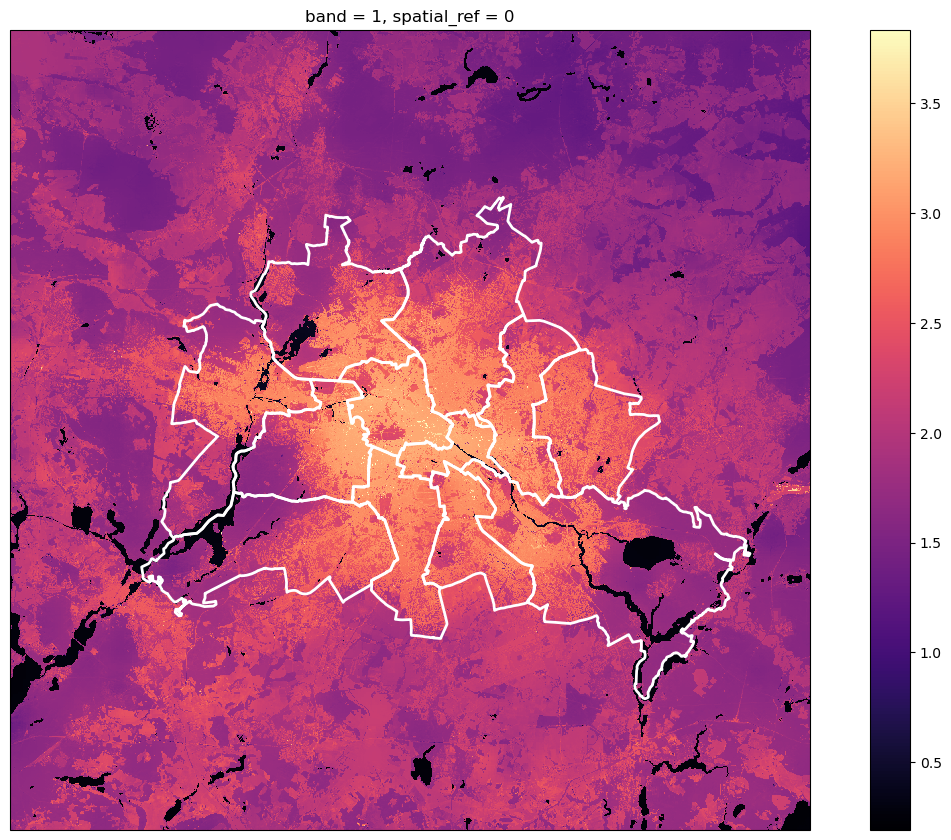

In [6]:
fig=plt.figure(figsize=[12,8])
ax = fig.add_axes([0,0,1,1],projection=ccrs.UTM(32))
raster_image=hwmi.plot(ax=ax, cmap="magma")
districts.plot(ax=ax,color='none', edgecolor="white",linewidth=2)
plt.show()

In [7]:
# extract the mean HWMI value for each district
districts["hwmi_mean"] = districts.geometry.apply(
    lambda geom: hwmi.sel(x=geom.centroid.x, y=geom.centroid.y, method="nearest").mean().item()
)
# display the districts with the mean HWMI value
districts.explore("hwmi_mean", tiles="CartoDB positron", cmap="viridis")


In [8]:
import geowombat as gw
with gw.open(datafolder + "/HWMI_2011_2020_present_30.tif") as src:
    df = gw.extract(src, datafolder + "/city/Bezirksgrenzen.shp")

df.rename(columns={1 : "hwmi_extracted"}, inplace=True)

# join the mean HWMI value to the districts GeoDataFrame
districts = districts.merge(df.groupby("gem").mean("hwmi_extracted").reset_index(), on="gem")

districts


d:\gitscripts\brandenburg-drought-study\.conda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gem                      namgem  namlan lan      name  \
0   003                      Pankow  Berlin  11  11000003   
1   009            Treptow-Köpenick  Berlin  11  11000009   
2   007        Tempelhof-Schöneberg  Berlin  11  11000007   
3   002    Friedrichshain-Kreuzberg  Berlin  11  11000002   
4   011                 Lichtenberg  Berlin  11  11000011   
5   004  Charlottenburg-Wilmersdorf  Berlin  11  11000004   
6   010         Marzahn-Hellersdorf  Berlin  11  11000010   
7   005                     Spandau  Berlin  11  11000005   
8   012               Reinickendorf  Berlin  11  11000012   
9   001                       Mitte  Berlin  11  11000001   
10  008                    Neukölln  Berlin  11  11000008   
11  006         Steglitz-Zehlendorf  Berlin  11  11000006   

                                             geometry  hwmi_mean    id  \
0   MULTIPOLYGON (((391281.076 5834094.026, 391278...   2.786919   0.0   
1   POLYGON ((413187.446 5812466.254, 413188.668 5...   1.811205   1.0   
2   POLYGON ((390305.591 5804288.293, 390302.578 5...   2.870324   2.0   
3   POLYGON ((394754.189 5820768.235, 394757.396 5...   3.163864   3.0   
4   POLYGON ((399797.137 5827986.437, 399859.451 5...   2.847373   4.0   
5   POLYGON ((386007.534 5820640.410, 386013.008 5...   2.615367   5.0   
6   POLYGON ((405800.725 5814456.489, 405787.202 5...   2.683085   6.0   
7   POLYGON ((379859.154 5825626.683, 379867.377 5...   2.845112   7.0   
8   POLYGON ((386338.951 5832057.891, 386358.829 5...   2.917237   8.0   
9   POLYGON ((390097.493 5825221.615, 390102.570 5...   3.223138   9.0   
10  POLYGON ((395329.759 5808949.912, 395296.306 5...   2.907949  10.0   
11  POLYGON ((385687.119 5814315.680, 385772.481 5...   2.043025  11.0   

       point  hwmi_extracted  
0    57324.0        2.416582  
1   207781.0        1.954545  
2   330370.0        2.720608  
3   371149.5        2.939850  
4   411410.5        2.674455  
5   476273.0        2.405335  
6   546517.5        2.570552  
7   631872.0        2.192254  
8   732506.0        2.223285  
9   803986.0        3.013970  
10  850811.5        2.667822  
11  932705.5        2.045219

In [9]:
districts.explore("hwmi_extracted", tiles="CartoDB positron", cmap="viridis")


### Grey-Blue-Green: Buildings, Roads, Water, and Parks

In the next step, we want to check how temperature differs with distance to urban land cover

1. Extract buildings, roads, water, parks, and tabulate heat distributions
2. Calculate distance decay / plot 
3. Train XGBoost to predict temperature
4. Inspect SHAP